In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree



In [2]:
df = pd.read_csv(r"C:\Users\temisola\DMML-Dubai-UG-Group-2\Datasets\processed\tabular_data\brain_tumor_dataset.csv")

In [3]:
#defining input and target classes

X = df.drop(columns = ['Patient_ID', 'Histology'])
#input features
y = df['Histology']
# target variable

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

preprocess = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

#Encode Y to convert to numbers for easier classification

In [5]:
#checking the shapes of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X columns:", X.columns[:10])

X shape: (20000, 17)
y shape: (20000,)
X columns: Index(['Age', 'Gender', 'Tumor_Type', 'Tumor_Size', 'Location', 'Stage',
       'Symptom_1', 'Symptom_2', 'Symptom_3', 'Radiation_Treatment'],
      dtype='object')


In [6]:
#inspect training set
print("Any missing values?", X.isnull().sum().sum() > 0)
print("Number of features:", X.shape[1])
print("Target classes:", pd.Series(y).value_counts())

new_cols = X.columns
print("Encoded feature names:\n", new_cols)
print("Total features:", len(new_cols))

Any missing values? False
Number of features: 17
Target classes: Histology
Glioblastoma       5068
Meningioma         5016
Medulloblastoma    4979
Astrocytoma        4937
Name: count, dtype: int64
Encoded feature names:
 Index(['Age', 'Gender', 'Tumor_Type', 'Tumor_Size', 'Location', 'Stage',
       'Symptom_1', 'Symptom_2', 'Symptom_3', 'Radiation_Treatment',
       'Surgery_Performed', 'Chemotherapy', 'Survival_Rate',
       'Tumor_Growth_Rate', 'Family_History', 'MRI_Result',
       'Follow_Up_Required'],
      dtype='object')
Total features: 17


In [7]:
#next, train a machine learning model 
#initialize the model

dt_model = DecisionTreeClassifier(
    random_state=42,     # For reproducibility
)
pipe = Pipeline([("prep", preprocess), ("clf", dt_model)])

In [8]:
# split the dataset for training and testing 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    #test size of 20%
    random_state=42,  
    stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

#checking the distribution of classes in training and test sets

Training set size: (16000, 17)
Test set size: (4000, 17)


In [16]:
#train the model.
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)  
y_pred = pipe.predict(X_test)

In [ ]:
#hyperparameter tuning using GridSearchCV
param_grid = {"clf__criterion": ["gini", "entropy"],
              "clf__max_depth": [3, 5, 8, 12],
              "clf__min_samples_split": [2, 20, 100],
              "clf__min_samples_leaf": [1, 10, 40],}
grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=3, scoring="accuracy", 
    n_jobs=-1)
grid.fit(X_train, y_train)

# After pipe.fit(...) / grid.fit(...)
y_train_pred = grid.predict(X_train)      
y_test_pred = grid.predict(X_test)

print("Best params:", grid.best_params_)      # best settings
print("Mean CV accuracy:", grid.best_score_)  # mean CV accuracy

best_model = grid.best_estimator_
cat_names = best_model.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_names)
importances = best_model.named_steps["clf"].feature_importances_


Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2}
Mean CV accuracy: 0.25987474423375684


In [13]:
y_pred = grid.predict(X_test)

#make predictions on the test set
print("First 20 predictions:", y_pred[:20])
for actual, predicted in zip(y_test[:20], y_pred[:20]):
    print(f"Actual: {actual}, Predicted: {predicted}")

First 20 predictions: ['Glioblastoma' 'Glioblastoma' 'Medulloblastoma' 'Glioblastoma'
 'Glioblastoma' 'Medulloblastoma' 'Medulloblastoma' 'Medulloblastoma'
 'Astrocytoma' 'Glioblastoma' 'Glioblastoma' 'Glioblastoma' 'Glioblastoma'
 'Glioblastoma' 'Glioblastoma' 'Glioblastoma' 'Medulloblastoma'
 'Medulloblastoma' 'Medulloblastoma' 'Medulloblastoma']
Actual: Meningioma, Predicted: Glioblastoma
Actual: Astrocytoma, Predicted: Glioblastoma
Actual: Medulloblastoma, Predicted: Medulloblastoma
Actual: Astrocytoma, Predicted: Glioblastoma
Actual: Glioblastoma, Predicted: Glioblastoma
Actual: Meningioma, Predicted: Medulloblastoma
Actual: Astrocytoma, Predicted: Medulloblastoma
Actual: Astrocytoma, Predicted: Medulloblastoma
Actual: Astrocytoma, Predicted: Astrocytoma
Actual: Medulloblastoma, Predicted: Glioblastoma
Actual: Glioblastoma, Predicted: Glioblastoma
Actual: Glioblastoma, Predicted: Glioblastoma
Actual: Glioblastoma, Predicted: Glioblastoma
Actual: Astrocytoma, Predicted: Glioblastom

In [14]:
# shapes
print("X_train, X_test, y_train, y_test shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# unique classes and counts
print("\nUnique classes (encoded):", np.unique(y))
print("\nTrain class distribution:\n", pd.Series(y_train).value_counts())
print("\nTest class distribution:\n", pd.Series(y_test).value_counts())


# baseline performance (is the model worse than random/majority?)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print("\nDummy (majority) accuracy on test:", dummy.score(X_test, y_test))

# basic classification report and confusion matrix
print("\nClassification report for your model:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


X_train, X_test, y_train, y_test shapes: (16000, 17) (4000, 17) (16000,) (4000,)

Unique classes (encoded): ['Astrocytoma' 'Glioblastoma' 'Medulloblastoma' 'Meningioma']

Train class distribution:
 Histology
Glioblastoma       4054
Meningioma         4013
Medulloblastoma    3983
Astrocytoma        3950
Name: count, dtype: int64

Test class distribution:
 Histology
Glioblastoma       1014
Meningioma         1003
Medulloblastoma     996
Astrocytoma         987
Name: count, dtype: int64

Dummy (majority) accuracy on test: 0.2535

Classification report for your model:
                 precision    recall  f1-score   support

    Astrocytoma       0.26      0.06      0.10       987
   Glioblastoma       0.26      0.48      0.34      1014
Medulloblastoma       0.26      0.36      0.30       996
     Meningioma       0.29      0.16      0.21      1003

       accuracy                           0.27      4000
      macro avg       0.27      0.26      0.24      4000
   weighted avg       0.27  

Training Accuracy: 0.2787
Test Accuracy: 0.2660


[Text(0.4642857142857143, 0.9, 'Survival_Rate <= 70.874\nentropy = 2.0\nsamples = 16000\nvalue = [3950.0, 4054.0, 3983.0, 4013.0]\nclass = Glioblastoma'),
 Text(0.2857142857142857, 0.7, 'Survival_Rate <= 70.837\nentropy = 1.999\nsamples = 8190\nvalue = [1953, 2172, 2021, 2044]\nclass = Glioblastoma'),
 Text(0.375, 0.8, 'True  '),
 Text(0.21428571428571427, 0.5, 'Tumor_Size <= 9.983\nentropy = 1.999\nsamples = 8178\nvalue = [1951, 2165, 2021, 2041]\nclass = Glioblastoma'),
 Text(0.14285714285714285, 0.3, 'Tumor_Size <= 8.568\nentropy = 1.999\nsamples = 8167\nvalue = [1951, 2160, 2020, 2036]\nclass = Glioblastoma'),
 Text(0.07142857142857142, 0.1, '\n  (...)  \n'),
 Text(0.21428571428571427, 0.1, '\n  (...)  \n'),
 Text(0.2857142857142857, 0.3, 'entropy = 1.349\nsamples = 11\nvalue = [0, 5, 1, 5]\nclass = Glioblastoma'),
 Text(0.35714285714285715, 0.5, 'entropy = 1.384\nsamples = 12\nvalue = [2, 7, 0, 3]\nclass = Glioblastoma'),
 Text(0.6428571428571429, 0.7, 'Survival_Rate <= 70.952\nen

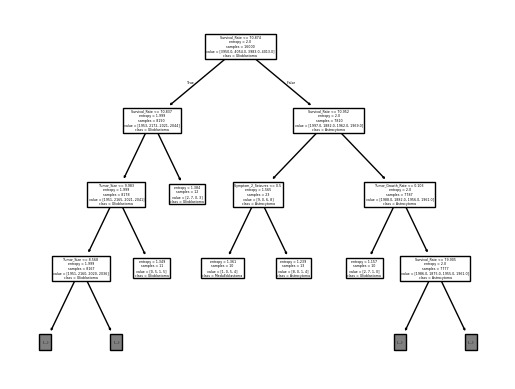

In [ ]:
# Predictions on training set

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize the decision tree (limited depth for clarity)
fitted_tree = grid.best_estimator_.named_steps["clf"]
feature_names = num_cols + list(
    grid.best_estimator_.named_steps["prep"]
        .named_transformers_["cat"]
        .get_feature_names_out(cat_cols)
)
tree.plot_tree(fitted_tree, feature_names=feature_names, class_names=sorted(y.unique()), max_depth=3)

This model performs really poorly

This is because Decision Tree Classifiers works well with data with >= 500 features.